# Project Introduction

This project focuses on enhancing low-light images using state-of-the-art deep learning techniques. We implement two prominent frameworks: **Zero-DCE** (Zero-Reference Deep Curve Estimation) and **ESRGAN** (Enhanced Super-Resolution Generative Adversarial Networks).

## Zero-DCE
The Zero-DCE approach allows for image enhancement without relying on paired datasets, leveraging deep learning models to adjust color and brightness effectively. By focusing on unpaired data, this method provides a robust solution for enhancing low-light images, ensuring natural color reproduction and improved visibility.

## ESRGAN
Building upon the foundational work of GANs (Generative Adversarial Networks), ESRGAN further refines the super-resolution process, enabling high-quality image enhancement. This framework combines the strengths of both perceptual loss functions and adversarial training to produce visually appealing results, making it an excellent choice for restoring fine details in low-light conditions.

## Streamlit
To facilitate user interaction and visualization, we integrate **Streamlit**, a powerful app framework for machine learning and data science projects. Streamlit allows users to upload low-light images, apply the enhancement techniques in real-time, and visualize the results seamlessly, making it an intuitive tool for exploring image enhancement workflows.



# Zero DCE

**Zero-Reference Deep Curve Estimation** or **Zero-DCE** formulates low-light image
enhancement as the task of estimating an image-specific
[*tonal curve*](https://en.wikipedia.org/wiki/Curve_(tonality)) with a deep neural network.
In this example, we train a lightweight deep network, **DCE-Net**, to estimate
pixel-wise and high-order tonal curves for dynamic range adjustment of a given image.

Zero-DCE takes a low-light image as input and produces high-order tonal curves as its output.
These curves are then used for pixel-wise adjustment on the dynamic range of the input to
obtain an enhanced image. The curve estimation process is done in such a way that it maintains
the range of the enhanced image and preserves the contrast of neighboring pixels. This
curve estimation is inspired by curves adjustment used in photo editing software such as
Adobe Photoshop where users can adjust points throughout an image’s tonal range.

Zero-DCE is appealing because of its relaxed assumptions with regard to reference images:
it does not require any input/output image pairs during training.
This is achieved through a set of carefully formulated non-reference loss functions,
which implicitly measure the enhancement quality and guide the training of the network.

### References

- [Zero-Reference Deep Curve Estimation for Low-Light Image Enhancement](https://arxiv.org/pdf/2001.06826.pdf)
- [Curves adjustment in Adobe Photoshop](https://helpx.adobe.com/photoshop/using/curves-adjustment.html)

## Downloading LOL Dataset

The **LoL Dataset** has been created for low-light image enhancement. It provides 480
images for training and 15 for testing. Each image pair in the dataset consists of a
low-light input image and its corresponding well-exposed reference image.

In [ ]:
!pip install -qU wandb

In [ ]:
import wandb
from wandb.integration.keras import WandbCallback

## Downloading Lol dataset using W&B Artifacts

In [ ]:
import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
run = wandb.init()
artifact = run.use_artifact('ivangoncharov/Low Light Enhancement with Zero-DCE/Lol_Dataset:v0', type='dataset')
artifact_dir = artifact.download()
artifact_path = os.path.join(artifact_dir, "lol_dataset.zip")
!unzip $artifact_path

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact Lol_Dataset:v0, 331.09MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:19.4


Archive:  /content/artifacts/Lol_Dataset:v0/lol_dataset.zip
   creating: lol_dataset/
   creating: lol_dataset/eval15/
   creating: lol_dataset/eval15/high/
  inflating: lol_dataset/eval15/high/748.png  
  inflating: lol_dataset/eval15/high/665.png  
  inflating: lol_dataset/eval15/high/111.png  
  inflating: lol_dataset/eval15/high/493.png  
  inflating: lol_dataset/eval15/high/22.png  
  inflating: lol_dataset/eval15/high/23.png  
  inflating: lol_dataset/eval15/high/669.png  
  inflating: lol_dataset/eval15/high/547.png  
  inflating: lol_dataset/eval15/high/778.png  
  inflating: lol_dataset/eval15/high/55.png  
  inflating: lol_dataset/eval15/high/179.png  
  inflating: lol_dataset/eval15/high/780.png  
  inflating: lol_dataset/eval15/high/79.png  
  inflating: lol_dataset/eval15/high/146.png  
  inflating: lol_dataset/eval15/high/1.png  
  inflating: lol_dataset/eval15/.DS_Store  
   creating: lol_dataset/eval15/low/
  inflating: lol_dataset/eval15/low/748.png  
  inflating: lol_

## Creating a TensorFlow Dataset

We use 300 low-light images from the LoL Dataset training set for training, and we use
the remaining 185 low-light images for validation. We resize the images to size `256 x
256` to be used for both training and validation. Note that in order to train the DCE-Net,
we will not require the corresponding enhanced images.

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


## The Zero-DCE Framework

The goal of DCE-Net is to estimate a set of best-fitting light-enhancement curves
(LE-curves) given an input image. The framework then maps all pixels of the input’s RGB
channels by applying the curves iteratively to obtain the final enhanced image.

### Understanding light-enhancement curves

A ligh-enhancement curve is a kind of curve that can map a low-light image
to its enhanced version automatically,
where the self-adaptive curve parameters are solely dependent on the input image.
When designing such a curve, three objectives should be taken into account:

- Each pixel value of the enhanced image should be in the normalized range `[0,1]`, in order to
avoid information loss induced by overflow truncation.
- It should be monotonous, to preserve the contrast between neighboring pixels.
- The shape of this curve should be as simple as possible,
and the curve should be differentiable to allow backpropagation.

The light-enhancement curve is separately applied to three RGB channels instead of solely on the
illumination channel. The three-channel adjustment can better preserve the inherent color and reduce
the risk of over-saturation.

![](https://li-chongyi.github.io/Zero-DCE_files/framework.png)

### DCE-Net

The DCE-Net is a lightweight deep neural network that learns the mapping between an input
image and its best-fitting curve parameter maps. The input to the DCE-Net is a low-light
image while the outputs are a set of pixel-wise curve parameter maps for corresponding
higher-order curves. It is a plain CNN of seven convolutional layers with symmetrical
concatenation. Each layer consists of 32 convolutional kernels of size 3×3 and stride 1
followed by the ReLU activation function. The last convolutional layer is followed by the
Tanh activation function, which produces 24 parameter maps for 8 iterations, where each
iteration requires three curve parameter maps for the three channels.

![](https://i.imgur.com/HtIg34W.png)

In [ ]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)


## Loss functions

To enable zero-reference learning in DCE-Net, we use a set of differentiable
zero-reference losses that allow us to evaluate the quality of enhanced images.

### Color constancy loss

The *color constancy loss* is used to correct the potential color deviations in the
enhanced image.

In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))


### Exposure loss

To restrain under-/over-exposed regions, we use the *exposure control loss*.
It measures the distance between the average intensity value of a local region
and a preset well-exposedness level (set to `0.6`).

In [ ]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))


### Illumination smoothness loss

To preserve the monotonicity relations between neighboring pixels, the
*illumination smoothness loss* is added to each curve parameter map.

In [ ]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size


### Spatial consistency loss

The *spatial consistency loss* encourages spatial coherence of the enhanced image by
preserving the contrast between neighboring regions across the input image and its enhanced version.

In [ ]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down


### Deep curve estimation model

We implement the Zero-DCE framework as a Keras subclassed model.

In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )
        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            # options=options,
        )


In [ ]:
wandb.init(project="low_light_zero_DCE", job_type="training")

## Training

In [ ]:
wandb.config.learning_rate = 1e-4

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 354ms/step - color_constancy_loss: 0.0026 - exposure_loss: 2.9279 - illumination_smoothness_loss: 2.0746 - spatial_constancy_loss: 2.6866e-05 - total_loss: 5.0052 - val_color_constancy_loss: 4.7455e-04 - val_exposure_loss: 2.9993 - val_illumination_smoothness_loss: 1.4494 - val_spatial_constancy_loss: 2.8621e-05 - val_total_loss: 4.4493
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - color_constancy_loss: 0.0024 - exposure_loss: 2.9202 - illumination_smoothness_loss: 1.3006 - spatial_constancy_loss: 3.2321e-05 - total_loss: 4.2233 - val_color_constancy_loss: 4.4999e-04 - val_exposure_loss: 2.9922 - val_illumination_smoothness_loss: 0.9178 - val_spatial_constancy_loss: 3.6623e-05 - val_total_loss: 3.9105
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - color_constancy_loss: 0.0025 - exposure_loss: 2.9104 - illumination_smoothness_loss: 0.8908 - spatial_constancy_loss: 4.7059e-05 - total_loss: 3.8037 - val_color_constancy_loss: 4.5772e

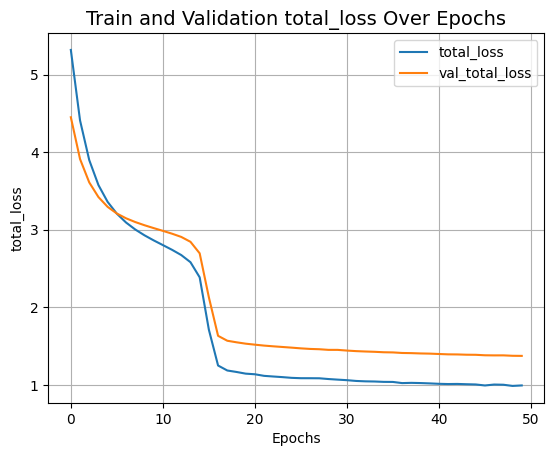

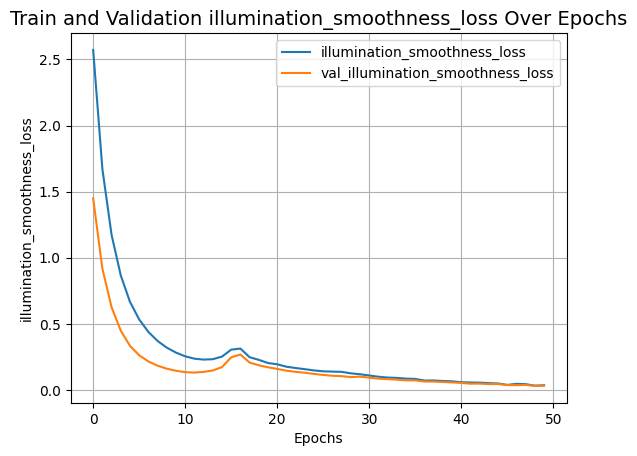

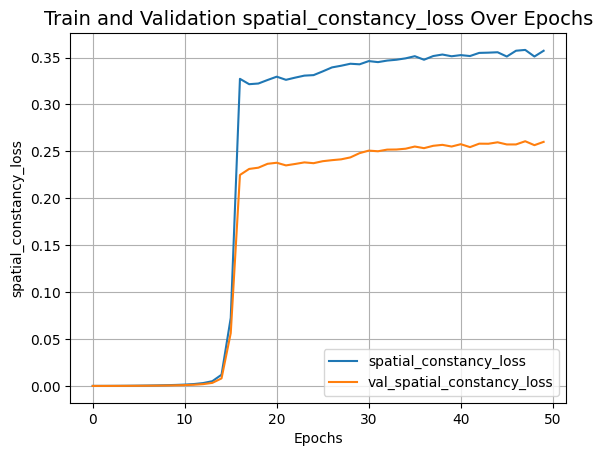

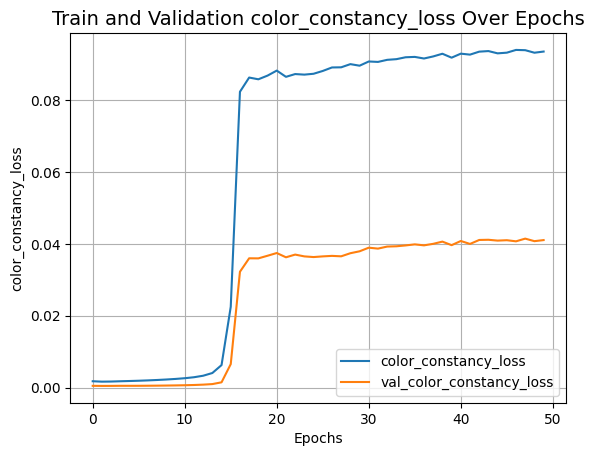

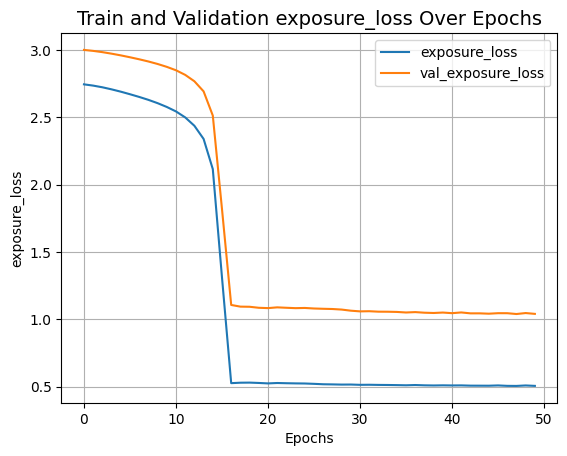

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=wandb.config.learning_rate)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[WandbCallback()])


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [ ]:
zero_dce_model.dce_model.save("model.h5")

## Inference

In [ ]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [ ]:
# Load your trained ZeroDCE model
zero_dce_model = ZeroDCE()  # Initialize the model
zero_dce_model.load_weights("model.h5")  # Load the saved weights

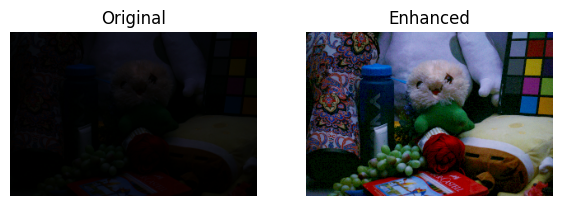

In [ ]:
# Load your single test image
test_image_path = 'resized_493.png'  # Replace with your image path
original_image = Image.open(test_image_path)

enhanced_image = infer(original_image)

enhanced_image_path = "enhanced_image.png"
enhanced_image.save(enhanced_image_path)

fig, axes = plt.subplots(1, 2, figsize=(7, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis('off')



axes[1].imshow(enhanced_image)
axes[1].set_title("Enhanced")
axes[1].axis('off')

plt.show()


# Image Super Resolution using ESRGAN

**Preparing Environment**

In [ ]:
import time
import tensorflow_hub as hub
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
# Declaring Constants
IMAGE_PATH = "enhanced_image.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

#### Performing Super Resolution of images loaded from path

In [ ]:
hr_image = preprocess_image(IMAGE_PATH)

In [ ]:
model_ESRGAN = hub.load(SAVED_MODEL_PATH)

In [ ]:
start = time.time()
fake_image = model_ESRGAN(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 16.329827


Saved as Super Resolution.jpg


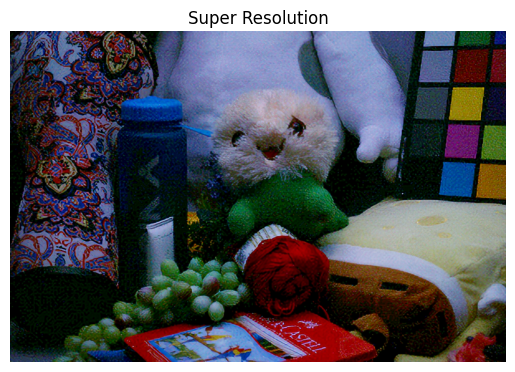

In [ ]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

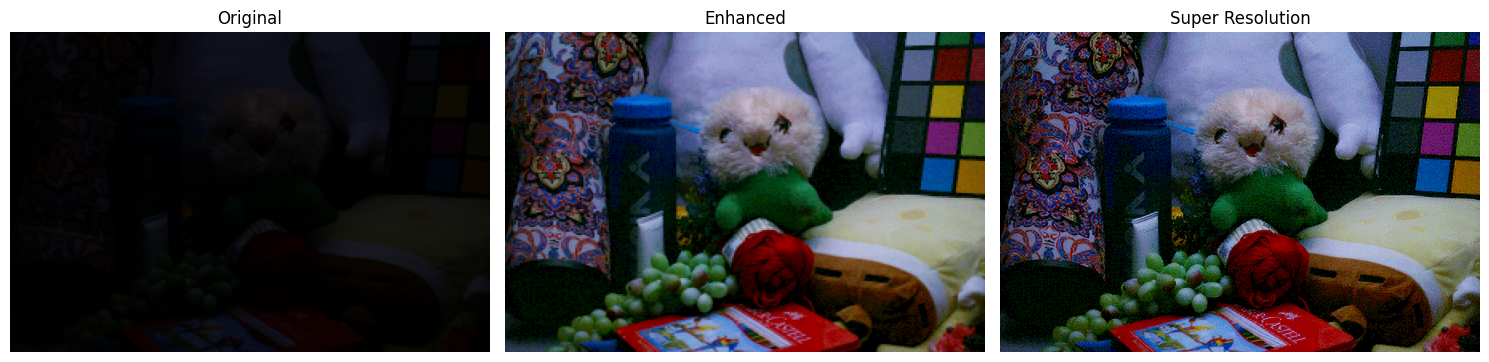

In [ ]:
# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a 1x3 grid for the images

# Original Image
axes[0].imshow(original_image)
axes[0].set_title("Original")
axes[0].axis('off')

# Enhanced Image
axes[1].imshow(enhanced_image)
axes[1].set_title("Enhanced")
axes[1].axis('off')

# Super Resolution Image using plot_image function
plot_image(tf.squeeze(fake_image), title="Super Resolution")
axes[2].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Metrics against Ground Truth:
SSIM: 0.5056, PSNR: 19.06, MAE: 203.53
Metrics against Low Light Image:
Contrast: 46.12, Colorfulness: 40.95, Sharpness: 285.22


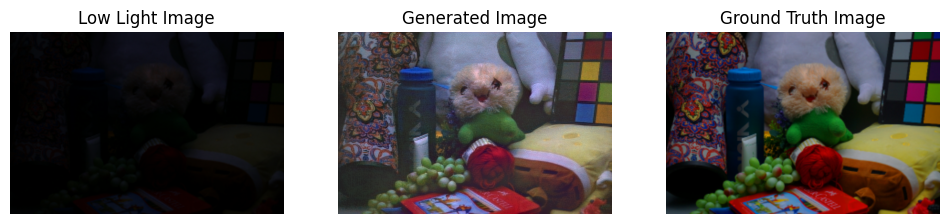

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from skimage import metrics

def calculate_ssim(imageA, imageB):
    imageA = tf.convert_to_tensor(imageA, dtype=tf.float32) / 255.0
    imageB = tf.convert_to_tensor(imageB, dtype=tf.float32) / 255.0
    ssim = tf.image.ssim(imageA, imageB, max_val=1.0)
    return ssim.numpy()

def calculate_psnr(imageA, imageB):
    return metrics.peak_signal_noise_ratio(imageA, imageB)

def calculate_mae(imageA, imageB):
    return mean_absolute_error(imageA.flatten(), imageB.flatten())

def calculate_contrast(image):
    return np.std(image)

def calculate_colorfulness(image):
    image = image.astype("float32")
    (B, G, R) = cv2.split(image)
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    return np.mean(rg) + np.mean(yb)

def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

def display_metrics(low_light_image, generated_image, ground_truth_image=None):
    # Resize the low_light_image to match generated_image dimensions
    low_light_image = cv2.resize(low_light_image, (generated_image.shape[1], generated_image.shape[0]))
    low_light_image = cv2.cvtColor(low_light_image, cv2.COLOR_BGR2RGB)
    generated_image = cv2.cvtColor(generated_image, cv2.COLOR_BGR2RGB)

    # Calculate metrics
    ssim = calculate_ssim(generated_image, low_light_image)
    psnr = calculate_psnr(generated_image, low_light_image)
    mae = calculate_mae(generated_image, low_light_image)
    contrast = calculate_contrast(generated_image)
    colorfulness = calculate_colorfulness(generated_image)
    sharpness = calculate_sharpness(generated_image)

    # If ground truth is available, resize it to match generated image dimensions
    if ground_truth_image is not None:
        ground_truth_image = cv2.resize(ground_truth_image, (generated_image.shape[1], generated_image.shape[0]))
        ground_truth_image = cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB)
        ssim_gt = calculate_ssim(generated_image, ground_truth_image)
        psnr_gt = calculate_psnr(generated_image, ground_truth_image)
        mae_gt = calculate_mae(generated_image, ground_truth_image)

        print("Metrics against Ground Truth:")
        print(f"SSIM: {ssim_gt:.4f}, PSNR: {psnr_gt:.2f}, MAE: {mae_gt:.2f}")

    # Display metrics
    print("Metrics against Low Light Image:")
    print(f"Contrast: {contrast:.2f}, Colorfulness: {colorfulness:.2f}, Sharpness: {sharpness:.2f}")

    # Optionally display the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(low_light_image)
    plt.title('Low Light Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(generated_image)
    plt.title('Generated Image')
    plt.axis('off')

    if ground_truth_image is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_image)
        plt.title('Ground Truth Image')
        plt.axis('off')

    plt.show()

# Example usage:
low_light_img = cv2.imread('resized_493.png')
generated_img = cv2.imread('EnlightenGAN_rlt.png')
ground_truth_img = cv2.imread('resized_493_gt.png')  # Optional

display_metrics(low_light_img, generated_img, ground_truth_img)

# Streamlit UI

In [ ]:
! pip install streamlit -q

In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.197.36.243


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image, ImageOps

import os
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_absolute_error
from skimage import metrics
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"


def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.dce_model = build_dce_net()

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            # options=options,
        )


def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

# Metric calculation functions
def calculate_ssim(imageA, imageB):
    imageA = tf.convert_to_tensor(imageA, dtype=tf.float32) / 255.0
    imageB = tf.convert_to_tensor(imageB, dtype=tf.float32) / 255.0
    ssim = tf.image.ssim(imageA, imageB, max_val=1.0)
    return ssim.numpy()

def calculate_psnr(imageA, imageB):
    return metrics.peak_signal_noise_ratio(imageA, imageB)

def calculate_mae(imageA, imageB):
    return mean_absolute_error(imageA.flatten(), imageB.flatten())

def calculate_contrast(image):
    return np.std(image)

def calculate_colorfulness(image):
    image = image.astype("float32")
    (B, G, R) = cv2.split(image)
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    return np.mean(rg) + np.mean(yb)

def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

# Display metrics
def display_metrics(low_light_image, generated_image, ground_truth_image=None):
    # Resize low_light_image to match generated_image dimensions
    low_light_image = cv2.resize(low_light_image, (generated_image.shape[1], generated_image.shape[0]))

    # Calculate metrics
    contrast = calculate_contrast(generated_image)
    colorfulness = calculate_colorfulness(generated_image)
    sharpness = calculate_sharpness(generated_image)

    st.write("### Metrics against Low Light Image")
    st.write(f"Contrast: {contrast:.2f}")
    st.write(f"Colorfulness: {colorfulness:.2f}")
    st.write(f"Sharpness: {sharpness:.2f}")

    if ground_truth_image is not None:
        ground_truth_image = cv2.resize(ground_truth_image, (generated_image.shape[1], generated_image.shape[0]))
        ssim_gt = calculate_ssim(generated_image, ground_truth_image)
        psnr_gt = calculate_psnr(generated_image, ground_truth_image)
        mae_gt = calculate_mae(generated_image, ground_truth_image)

        st.write("### Metrics against Ground Truth Image")
        st.write(f"SSIM: {ssim_gt:.4f}")
        st.write(f"PSNR: {psnr_gt:.2f} dB")
        st.write(f"MAE: {mae_gt:.2f}")


st.title("Image Enhancement App")

# Load your trained ZeroDCE model
zero_dce_model = ZeroDCE()  # Initialize the model
zero_dce_model.load_weights("model.h5")  # Load the saved weights
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
model_ESRGAN = hub.load(SAVED_MODEL_PATH)

uploaded_file = st.file_uploader("Upload Low Light Image", type=["jpg", "png", "jpeg"])
ground_truth_file = st.file_uploader("Upload Ground Truth Image (Optional)", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    original_image = Image.open(uploaded_file)
    enhanced_image = infer(original_image)

    st.subheader("Original Image")
    st.image(original_image, use_column_width=True)


    st.subheader("Enhanced Image")
    st.image(enhanced_image, use_column_width=True)
    enhanced_image.save("enhanced_image.png")


    IMAGE_PATH = "enhanced_image.png"

    # Preprocess the image
    hr_image = preprocess_image(IMAGE_PATH)

    # Load the model
    model_ESRGAN = hub.load(SAVED_MODEL_PATH)

    # Generate super-resolution image
    fake_image = model_ESRGAN(hr_image)
    fake_image = np.asarray(tf.squeeze(fake_image))
    fake_image = tf.clip_by_value(fake_image, 0, 255)
    fake_image = Image.fromarray(tf.cast(fake_image, tf.uint8).numpy())

    st.subheader("High Resolution Image")
    st.image(fake_image, use_column_width=True)
    fake_image.save("highres_image.jpg")

    # Convert images to OpenCV format for metric calculations
    low_light_cv2 = np.array(original_image.convert("RGB"))
    high_res_cv2 = np.array(fake_image.convert("RGB"))

    ground_truth_cv2 = None
    if ground_truth_file is not None:
        ground_truth_image = Image.open(ground_truth_file)
        st.subheader("Ground Truth Image")
        st.image(ground_truth_image, use_column_width=True)
        ground_truth_cv2 = np.array(ground_truth_image.convert("RGB"))

    # Display metrics
    if st.button("Calculate Metrics"):
        display_metrics(low_light_cv2, high_res_cv2, ground_truth_cv2)


    st.success("Images saved as enhanced_image and highres_image")


Overwriting app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.36.243:8501

your url is: https://puny-views-lick.loca.lt
2024-11-03 17:25:27.709959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 17:25:27.733583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 17:25:27.740538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 17:25:27.756674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instru

In [ ]:
# %%writefile app.py
# import streamlit as st
# from PIL import Image, ImageOps

# import os
# import random
# import numpy as np
# from glob import glob
# from PIL import Image, ImageOps
# import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_hub as hub

# os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"


# def build_dce_net():
#     input_img = keras.Input(shape=[None, None, 3])
#     conv1 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(input_img)
#     conv2 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(conv1)
#     conv3 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(conv2)
#     conv4 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(conv3)
#     int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
#     conv5 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(int_con1)
#     int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
#     conv6 = layers.Conv2D(
#         32, (3, 3), strides=(1, 1), activation="relu", padding="same"
#     )(int_con2)
#     int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
#     x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
#         int_con3
#     )
#     return keras.Model(inputs=input_img, outputs=x_r)

# class ZeroDCE(keras.Model):
#     def __init__(self, **kwargs):
#         super(ZeroDCE, self).__init__(**kwargs)
#         self.dce_model = build_dce_net()

#     def get_enhanced_image(self, data, output):
#         r1 = output[:, :, :, :3]
#         r2 = output[:, :, :, 3:6]
#         r3 = output[:, :, :, 6:9]
#         r4 = output[:, :, :, 9:12]
#         r5 = output[:, :, :, 12:15]
#         r6 = output[:, :, :, 15:18]
#         r7 = output[:, :, :, 18:21]
#         r8 = output[:, :, :, 21:24]
#         x = data + r1 * (tf.square(data) - data)
#         x = x + r2 * (tf.square(x) - x)
#         x = x + r3 * (tf.square(x) - x)
#         enhanced_image = x + r4 * (tf.square(x) - x)
#         x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
#         x = x + r6 * (tf.square(x) - x)
#         x = x + r7 * (tf.square(x) - x)
#         enhanced_image = x + r8 * (tf.square(x) - x)
#         return enhanced_image

#     def call(self, data):
#         dce_net_output = self.dce_model(data)
#         return self.get_enhanced_image(data, dce_net_output)

#     def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
#         """While loading the weights, we simply load the weights of the DCE-Net"""
#         self.dce_model.load_weights(
#             filepath=filepath,
#             by_name=by_name,
#             skip_mismatch=skip_mismatch,
#             # options=options,
#         )


# def infer(original_image):
#     image = keras.preprocessing.image.img_to_array(original_image)
#     image = image.astype("float32") / 255.0
#     image = np.expand_dims(image, axis=0)
#     output_image = zero_dce_model(image)
#     output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
#     output_image = Image.fromarray(output_image.numpy())
#     return output_image

# SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

# def preprocess_image(image_path):
#   """ Loads image from path and preprocesses to make it model ready
#       Args:
#         image_path: Path to the image file
#   """
#   hr_image = tf.image.decode_image(tf.io.read_file(image_path))
#   # If PNG, remove the alpha channel. The model only supports
#   # images with 3 color channels.
#   if hr_image.shape[-1] == 4:
#     hr_image = hr_image[...,:-1]
#   hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
#   hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
#   hr_image = tf.cast(hr_image, tf.float32)
#   return tf.expand_dims(hr_image, 0)

# st.title("Image Enhancement App")


# # Load your trained ZeroDCE model
# zero_dce_model = ZeroDCE()  # Initialize the model
# zero_dce_model.load_weights("model.h5")  # Load the saved weights
# SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
# model_ESRGAN = hub.load(SAVED_MODEL_PATH)

# uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

# if uploaded_file is not None:
#     original_image = Image.open(uploaded_file)
#     enhanced_image = infer(original_image)

#     st.subheader("Original Image")
#     st.image(original_image, use_column_width=True)


#     st.subheader("Enhanced Image")
#     st.image(enhanced_image, use_column_width=True)
#     enhanced_image.save("enhanced_image.png")

#     IMAGE_PATH = "enhanced_image.png"

#     # Preprocess the image
#     hr_image = preprocess_image(IMAGE_PATH)

#     # Load the model
#     model_ESRGAN = hub.load(SAVED_MODEL_PATH)

#     # Generate super-resolution image
#     fake_image = model_ESRGAN(hr_image)
#     fake_image = np.asarray(tf.squeeze(fake_image))
#     fake_image = tf.clip_by_value(fake_image, 0, 255)
#     fake_image = Image.fromarray(tf.cast(fake_image, tf.uint8).numpy())

#     st.subheader("High Resolution Image")
#     st.image(fake_image, use_column_width=True)
#     fake_image.save("highres_image.jpg")
#     st.success("Images saved as enhanced_image and highres_image")
